In [423]:
# importing packages and data set

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


microbe_dataSet = pd.read_csv('data/mimedb_microbes.csv')
disbiome_dataSet = pd.read_csv('data/disbiome_data.csv')

# Understanding Microbiome Data Set

## Data Schema:

| **Column Name**          | **Description**                                          |
|--------------------------|----------------------------------------------------------|
| **id**                   | Unique identifier for each record                        |
| **microbe_id**           | Identifier for the microbe                               |
| **name**                 | The name of the microbe                                  |
| **superkingdom**         | The broader superkingdom classification                  |
| **kingdom**              | The biological kingdom to which the microbe belongs      |
| **phylum**               | The phylum classification of the microbe                 |
| **klass**                | The class classification of the microbe                  |
| **order**                | The order classification of the microbe                  |
| **family**               | The family classification of the microbe                 |
| **genus**                | The genus classification of the microbe                  |
| **species**              | The species of the microbe                               |
| **strain**               | The strain or subtype of the microbe                     |
| **parent_id**            | Identifier for the parent record (if applicable)         |
| **level**                | Hierarchical level or classification                     |
| **ncbi_tax_id**          | The NCBI taxonomy identifier for the microbe             |
| **activity**             | Indicates if the microbe is active or inactive           |
| **gram**                 | Gram staining characteristic (positive or negative)      |
| **oxygen_requirement**   | The type of oxygen requirement for the microbe           |
| **metabolism**           | The metabolic characteristics of the microbe             |
| **shape**                | The shape of the microbe (e.g., cocci, bacilli)          |
| **mobility**             | Indicates if the microbe is mobile or immobile           |
| **flagella_presence**    | Indicates the presence or absence of flagella            |
| **number_of_membranes**  | Number of membranes the microbe has                      |
| **optimal_temperature**  | The optimal temperature for the microbe's growth         |
| **temperature_range**    | The temperature range within which the microbe can grow  |
| **habitat**              | The natural habitat of the microbe                       |
| **biotic_relationship**  | The type of biotic relationship the microbe has          |
| **cell_arrangement**     | The arrangement of cells in the microbe                  |
| **sporulation**          | Indicates if the microbe can form spores                 |
| **energy_source**        | The type of energy source used by the microbe            |
| **background**           | Additional background information about the microbe      |
| **health_type**          | Indicates the health implications (e.g., pathogenic)     |
| **evidence_type**        | The type of evidence supporting the microbe's classification |
| **data_source**          | The source of the data                                   |
| **export**               | Export status or related information                     |
| **human_pathogen**       | Indicates if the microbe is a human pathogen             |
| **genome_ids**           | Associated genome identifiers                            |
| **created_at**           | The date and time when the record was created            |
| **updated_at**           | The date and time when the record was last updated       |

(P.S Generated by ChatGPT)

# Data Cleaning

In [424]:
def cleaning_oxy_req(ele):
    '''
    cleaned the input ele
    '''
    regex_pattern = r"/|;|,"

    if isinstance(ele, str):
        
        ele = re.split(regex_pattern, ele)[0]
        ele = ele.replace('\xa0', ' ')
        if ele == 'Nanaerobe':
            return 'Anaerobe'
        elif ele == 'Obligate anaerobe':
            return 'Anaerobe'
        elif ele == 'Facultatively anaerobe':
            return 'Facultative anaerobe'
        elif ele == 'Microaerophile':
            return 'Microaerophilic'
        else:
            return ele
    else:
        return ele

In [425]:
cleaned_microbe_dataSet = microbe_dataSet.copy()

# reduing the dimension of the oxygen_requirements types
# there is correct type and take the dominate type
cleaned_microbe_dataSet['oxygen_requirement'] = microbe_dataSet['oxygen_requirement'].apply(cleaning_oxy_req)

# find the association between the microbe and the source
# the source will be the most frequent source
taxid_sources = disbiome_dataSet[['subject_taxid', 'association_sources']].dropna().groupby(['subject_taxid']).apply(lambda df: df.value_counts().idxmax()[1]).reset_index().rename(columns={0: 'association_sources'})

# convert 'created_at' 
cleaned_microbe_dataSet['created_at_m'] = cleaned_microbe_dataSet['created_at'].apply(lambda time : pd.Timestamp(time).to_period('M').month)
cleaned_microbe_dataSet['update_at_m'] = cleaned_microbe_dataSet['updated_at'].apply(lambda time : pd.Timestamp(time).to_period('M').month)

# merging the two data set
complete_microbe_sources = pd.merge(cleaned_microbe_dataSet, taxid_sources, left_on='ncbi_tax_id', right_on='subject_taxid', how='inner')
incomeplete_microbe_sources = pd.merge(cleaned_microbe_dataSet, taxid_sources, left_on='ncbi_tax_id', right_on='subject_taxid', how='left')
complete_microbe_sources['tax_id'] = complete_microbe_sources['ncbi_tax_id']
complete_microbe_sources = complete_microbe_sources.drop(columns=['ncbi_tax_id', 'subject_taxid'])
incomeplete_microbe_sources['tax_id'] = incomeplete_microbe_sources['ncbi_tax_id']
incomeplete_microbe_sources = incomeplete_microbe_sources.drop(columns=['ncbi_tax_id', 'subject_taxid'])

In [426]:
complete_microbe_sources['association_sources'].value_counts()

feces                     243
subgingival plaque         48
saliva                     42
skin swab                  24
supragingival plaque       18
tissue biopsie             16
cervicovaginal lavage      15
vaginal swab               13
bronchoalveolar lavage      5
punch biopsie               5
bile                        4
urine                       4
cervical swabs              3
nasopharyngeal swab         3
oropharynx swab             3
oral swab                   3
dental plaque               3
vaginal fluid               2
plaque                      1
skin follicle               1
plasma                      1
nasal swab                  1
palatine tonsil swab        1
abscess pus                 1
detergent scrub             1
ulcerated tissue            1
sputum                      1
cervix swab                 1
appendix swab               1
colonoscopy aspirate        1
blood                       1
sinus brush                 1
Name: association_sources, dtype: int64

## Evaluating the Degree of Missingness of each column

### Visualizing Missing Value

In [427]:
# predefined functions

def eval_missing(df):
    '''
    find the porportion of missingness of each column in the table.
    return the result as a series
    '''
    summary = df.isna().mean()

    summary.sort_values().plot(kind = 'barh', figsize=(10, 10))
    # Adding title and labels
    plt.title('Percentage of missing values in each column')
    plt.xlabel('Columns')
    plt.ylabel('Percentage of missing values')

    plt.axvline(x=0.4, color='r', linestyle='--', linewidth=2)
    plt.show()

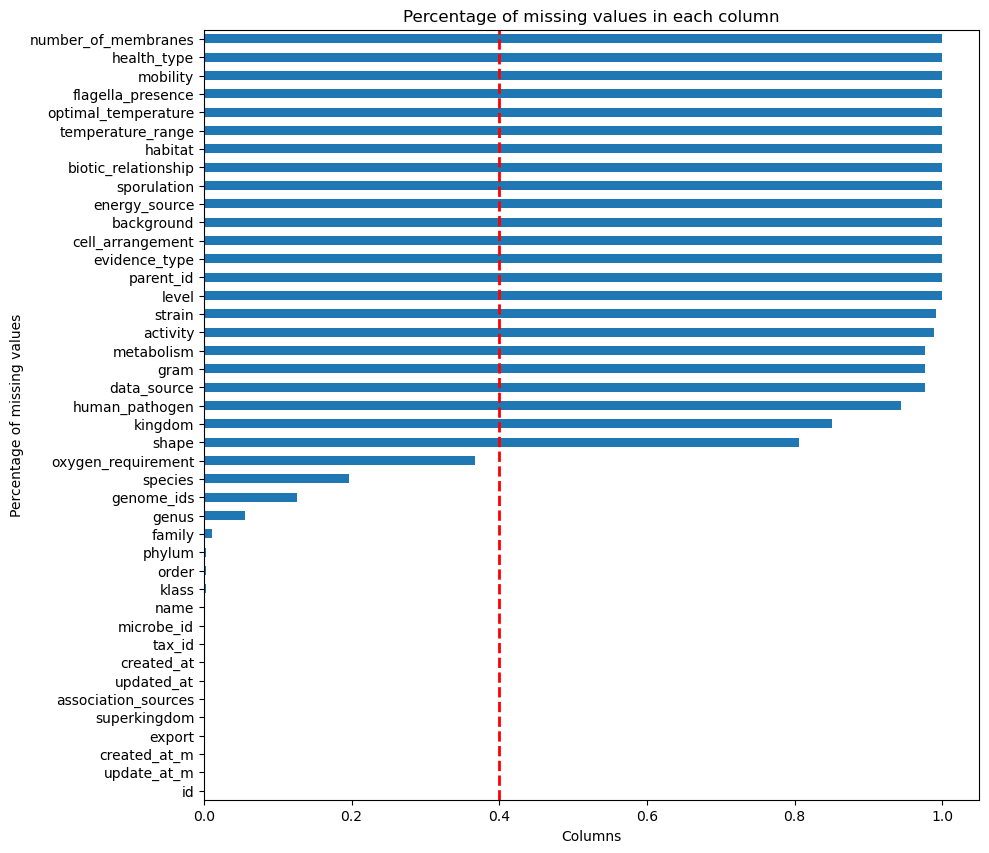

In [428]:
eval_missing(complete_microbe_sources)

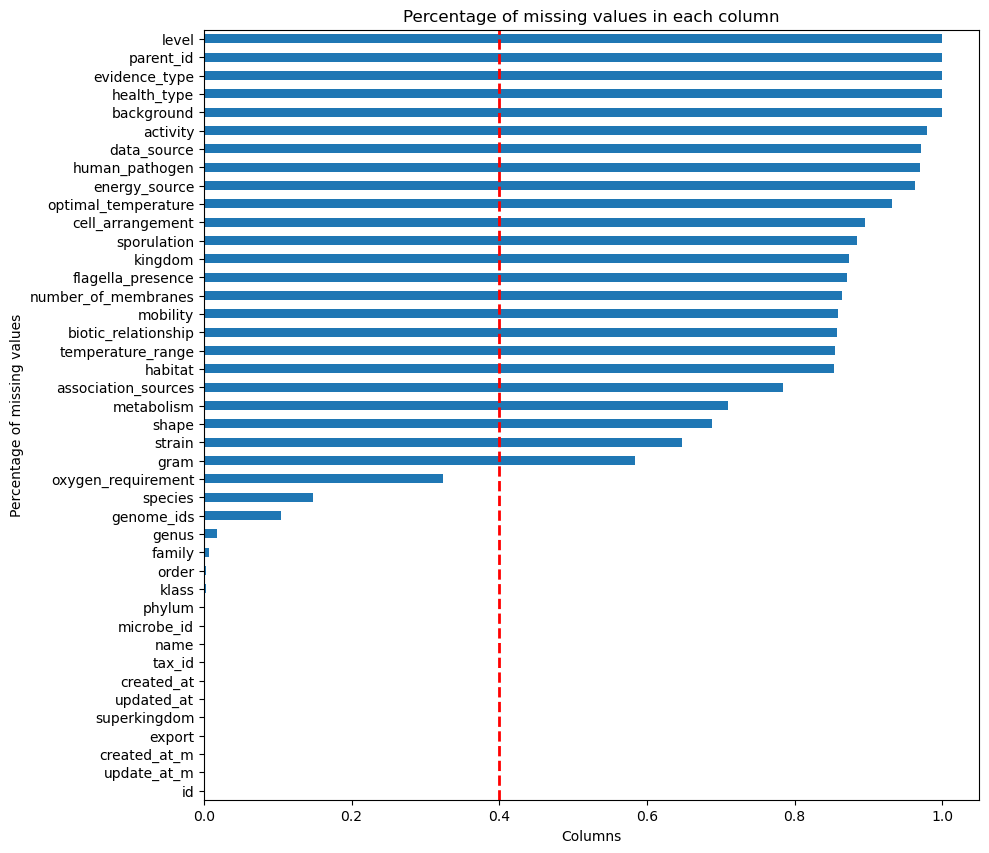

In [429]:
eval_missing(incomeplete_microbe_sources)

### Filtering Out columns that has more than 40% missing value and other identifier

In [430]:
filtered_complete_ms = complete_microbe_sources.drop(columns=complete_microbe_sources.columns[complete_microbe_sources.isna().mean() > 0.4])
filtered_incomplete_ms = incomeplete_microbe_sources.drop(columns=incomeplete_microbe_sources.columns[incomeplete_microbe_sources.isna().mean() > 0.4])

### Assessing the dependency of Missing rate in oxygen_requirements to other categorical columns

In [431]:
# conducting TVD analysis of column with missingness against others
def tvd_testing(missing_col, testingCol):
    '''
    Conduct TVD analysis of the missingness of a column against another column.
    return the TVD value
    ---
    missing_col: pd.Series
        the column with missingness
    testingCol: pd.Series
        the column to test against
    ---
    return: float
        the TVD value
    '''
    missing_mask = missing_col.isnull()

    missing_testingCol_prop = testingCol[missing_mask].value_counts(normalize=True)
    unMissing_testingCol_prop = testingCol[~missing_mask].value_counts(normalize=True)

    # find all categories for the purpose of comparsion
    all_tvd_categories = missing_testingCol_prop.index.union(unMissing_testingCol_prop.index)
    missing_testingCol_prop = missing_testingCol_prop.reindex(all_tvd_categories, fill_value=0)
    unMissing_testingCol_prop = unMissing_testingCol_prop.reindex(all_tvd_categories, fill_value=0)

    return np.abs(missing_testingCol_prop - unMissing_testingCol_prop).sum() / 2

In [432]:
tvd_testing_col = ['superkingdom', 'created_at_m', 'update_at_m', 'phylum', 'klass', 'order', 'family', 'genus', 'gram', 'export']

# check unqiue values for potential MAR columns
uniqueness = pd.DataFrame(columns=['column', 'unique_values'])
for col in tvd_testing_col:
    uniqueness = uniqueness.append({'column': col, 'unique_values': len(cleaned_microbe_dataSet[col].unique())}, ignore_index=True)
uniqueness.sort_values(by='unique_values')

,column,unique_values
9,export,1
0,superkingdom,4
2,update_at_m,4
1,created_at_m,7
8,gram,7
3,phylum,37
4,klass,80
5,order,159
6,family,299
7,genus,561


In [433]:
tvd_testing_col = ['superkingdom', 'created_at_m', 'update_at_m', 'phylum', 'klass', 'gram']


# conduct TVD analysis
tvd_results = pd.DataFrame(columns = ['column', 'tvd'])
for colName in tvd_testing_col:
    tvd = tvd_testing(complete_microbe_sources['oxygen_requirement'], complete_microbe_sources[colName])
    tvd_results = tvd_results.append({'column': colName, 'tvd': tvd}, ignore_index=True)
tvd_results.sort_values(by='tvd', ascending=False)

# tvd ranging from 0 to 1, the higher the value, the more likely the column is MAR
# MAR columns: the missing value is dependent on other columns
# the missingness of oxygen_requirement is somehow dependent on these columns
    # these columns are likely to be a good features to predict the missing value of oxygen_requirement

,column,tvd
5,gram,0.500000
4,klass,0.499170
3,phylum,0.424708
0,superkingdom,0.412791
2,update_at_m,0.395349
1,created_at_m,0.336109


Interpretation:
- High tvd value indicating great difference on the distribution of categories of the missing and non-missing value
- genus, family, order, klass might be miss leading due to its scarsity
- these columns can be used to predict the oxygen_requirements

## Data Imputation

In [434]:
CRITICAL_COL = ['superkingdom', 'created_at_m', 'update_at_m', 'phylum', 'klass', 'oxygen_requirement', 'association_sources']

In [435]:
# repalce all the missing value with the most frequent value
simple_imputation_df = filtered_complete_ms.copy()
simple_imputation_df['oxygen_requirement'] = simple_imputation_df['oxygen_requirement'].fillna(simple_imputation_df['oxygen_requirement'].value_counts().index[0])

In [436]:
# replace all the missing value based on the probabilistic model of the pre-exist data
prob_imputation_df = filtered_complete_ms.copy()
choices = np.array(prob_imputation_df['oxygen_requirement'].value_counts(normalize=True).index)
prob = np.array(prob_imputation_df['oxygen_requirement'].value_counts(normalize=True))
impute_value = np.random.choice(a = choices, size = prob_imputation_df['oxygen_requirement'].isna().sum(), p=prob)
prob_imputation_df.loc[prob_imputation_df['oxygen_requirement'].isna(), 'oxygen_requirement'] = impute_value

# we don't care about MAR

In [437]:
# replace all the missing value uses KNN model
knn_imputation_df = filtered_complete_ms.copy()

missing_data = knn_imputation_df[knn_imputation_df['oxygen_requirement'].isna()]
not_missing_data = knn_imputation_df[~knn_imputation_df['oxygen_requirement'].isna()]
 

# train knn model
train = not_missing_data[CRITICAL_COL].drop(columns=['oxygen_requirement', 'association_sources'])
predict = missing_data[CRITICAL_COL].drop(columns=['oxygen_requirement', 'association_sources'])
predict['phylum'] = predict['phylum'].fillna(predict['phylum'].value_counts().index[0])
predict['klass'] = predict['klass'].fillna(predict['klass'].value_counts().index[0])
label = not_missing_data['oxygen_requirement']

encoder = OrdinalEncoder()
encoded_train = encoder.fit_transform(train)
encoded_predict = encoder.fit_transform(predict)

model = KNeighborsClassifier()
model.fit(encoded_train, label)

# predict the missing value
predictions = model.predict(encoded_predict)
knn_imputation_df.loc[knn_imputation_df['oxygen_requirement'].isna(), 'oxygen_requirement'] = predictions

/opt/anaconda3/envs/scripps_microbiome/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [438]:
# replace all the missing value uses decision tree model
dt_imputation_df = filtered_complete_ms.copy()

missing_data = dt_imputation_df[dt_imputation_df['oxygen_requirement'].isna()]
not_missing_data = dt_imputation_df[~dt_imputation_df['oxygen_requirement'].isna()]
 

# train knn model
train = not_missing_data[CRITICAL_COL].drop(columns=['oxygen_requirement', 'association_sources'])
predict = missing_data[CRITICAL_COL].drop(columns=['oxygen_requirement', 'association_sources'])
predict['phylum'] = predict['phylum'].fillna(predict['phylum'].value_counts().index[0])
predict['klass'] = predict['klass'].fillna(predict['klass'].value_counts().index[0])
label = not_missing_data['oxygen_requirement']

encoder = OrdinalEncoder()
encoded_train = encoder.fit_transform(train)
encoded_predict = encoder.fit_transform(predict)

model = DecisionTreeClassifier()
model.fit(encoded_train, label)

# predict the missing value
predictions = model.predict(encoded_predict)
dt_imputation_df.loc[dt_imputation_df['oxygen_requirement'].isna(), 'oxygen_requirement'] = predictions

In [439]:
# replace all the missing value uses random forest model
rf_imputation_df = filtered_complete_ms.copy()

missing_data = rf_imputation_df[rf_imputation_df['oxygen_requirement'].isna()]
not_missing_data = rf_imputation_df[~rf_imputation_df['oxygen_requirement'].isna()]
 

# train knn model
train = not_missing_data[CRITICAL_COL].drop(columns=['oxygen_requirement', 'association_sources'])
predict = missing_data[CRITICAL_COL].drop(columns=['oxygen_requirement', 'association_sources'])
predict['phylum'] = predict['phylum'].fillna(predict['phylum'].value_counts().index[0])
predict['klass'] = predict['klass'].fillna(predict['klass'].value_counts().index[0])
label = not_missing_data['oxygen_requirement']

encoder = OrdinalEncoder()
encoded_train = encoder.fit_transform(train)
encoded_predict = encoder.fit_transform(predict)

model = RandomForestClassifier()
model.fit(encoded_train, label)

# predict the missing value
predictions = model.predict(encoded_predict)
rf_imputation_df.loc[rf_imputation_df['oxygen_requirement'].isna(), 'oxygen_requirement'] = predictions

In [440]:
# replace all the missing value uses random forest model -- special
rf_imputation_df_s = filtered_complete_ms.copy()

missing_data = rf_imputation_df_s[rf_imputation_df_s['oxygen_requirement'].isna()]
not_missing_data = rf_imputation_df_s[~rf_imputation_df_s['oxygen_requirement'].isna()]
 

# train knn model
train = not_missing_data[CRITICAL_COL].drop(columns=['oxygen_requirement', 'association_sources'])
predict = missing_data[CRITICAL_COL].drop(columns=['oxygen_requirement', 'association_sources'])
predict['phylum'] = predict['phylum'].fillna(predict['phylum'].value_counts().index[0])
predict['klass'] = predict['klass'].fillna(predict['klass'].value_counts().index[0])
label = not_missing_data['oxygen_requirement']

encoder = OrdinalEncoder()
encoded_train = encoder.fit_transform(train)
encoded_predict = encoder.fit_transform(predict)

model = RandomForestClassifier(bootstrap=True, max_depth=None, min_samples_leaf= 2, min_samples_split = 2, n_estimators = 200)
model.fit(encoded_train, label)

# predict the missing value
predictions = model.predict(encoded_predict)
rf_imputation_df_s.loc[rf_imputation_df_s['oxygen_requirement'].isna(), 'oxygen_requirement'] = predictions

In [441]:
# replace all the missing value uses logistic regression model
logistic_imputation_df = filtered_complete_ms.copy()

missing_data = logistic_imputation_df[logistic_imputation_df['oxygen_requirement'].isna()]
not_missing_data = logistic_imputation_df[~logistic_imputation_df['oxygen_requirement'].isna()]

# train knn model
train = not_missing_data[CRITICAL_COL].drop(columns=['oxygen_requirement', 'association_sources'])
predict = missing_data[CRITICAL_COL].drop(columns=['oxygen_requirement', 'association_sources'])
predict['phylum'] = predict['phylum'].fillna(predict['phylum'].value_counts().index[0])
predict['klass'] = predict['klass'].fillna(predict['klass'].value_counts().index[0])
label = not_missing_data['oxygen_requirement']

encoder = OrdinalEncoder()
encoded_train = encoder.fit_transform(train)
encoded_predict = encoder.fit_transform(predict)

model = LogisticRegression()
model.fit(encoded_train, label)

# predict the missing value
predictions = model.predict(encoded_predict)
logistic_imputation_df.loc[logistic_imputation_df['oxygen_requirement'].isna(), 'oxygen_requirement'] = predictions

/opt/anaconda3/envs/scripps_microbiome/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [442]:
# replace all the missing value uses SVC model
svc_imputation_df = filtered_complete_ms.copy()

missing_data = svc_imputation_df[svc_imputation_df['oxygen_requirement'].isna()]
not_missing_data = svc_imputation_df[~svc_imputation_df['oxygen_requirement'].isna()]

# train knn model
train = not_missing_data[CRITICAL_COL].drop(columns=['oxygen_requirement', 'association_sources'])
predict = missing_data[CRITICAL_COL].drop(columns=['oxygen_requirement', 'association_sources'])
predict['phylum'] = predict['phylum'].fillna(predict['phylum'].value_counts().index[0])
predict['klass'] = predict['klass'].fillna(predict['klass'].value_counts().index[0])
label = not_missing_data['oxygen_requirement']

encoder = OrdinalEncoder()
encoded_train = encoder.fit_transform(train)
encoded_predict = encoder.fit_transform(predict)

model = SVC()
model.fit(encoded_train, label)

predictions = model.predict(encoded_predict)
svc_imputation_df.loc[svc_imputation_df['oxygen_requirement'].isna(), 'oxygen_requirement'] = predictions

## Imputation evaluation

In [443]:
TEST_SIZE = 0.2

In [444]:
def logistic_regression_classification(df):
    '''
    TODO
    '''

    train = df[CRITICAL_COL]
    train = df.dropna()

    X = pd.get_dummies(train.drop('association_sources', axis=1), drop_first=True)

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(train['association_sources'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    return accuracy_score(y_test, y_pred)


In [445]:
class CustomCategoricalNB(CategoricalNB):
    def _joint_log_likelihood(self, X):
        jll = np.zeros((X.shape[0], len(self.classes_)))
        for i in range(self.n_features_in_):
            indices = X[:, i]
            # Handle unseen categories by assigning a small probability
            unseen_mask = indices >= self.feature_log_prob_[i].shape[1]
            indices[unseen_mask] = 0  # Assign unseen categories to index 0
            jll += self.feature_log_prob_[i][:, indices].T
            jll[unseen_mask, :] += np.log(0.1)  # Add log(0.1) for unseen categories
        total_ll = jll + self.class_log_prior_
        return total_ll

def naiveBased_classification(df):
    '''
    Perform Naive Bayes classification on the given DataFrame using CustomCategoricalNB.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing features and target.
    
    Returns:
    float: The accuracy score of the model.
    '''
    # Drop rows with missing values
    train = df.dropna()
    train = train[CRITICAL_COL]


    # Separate features and target
    X = train.drop(columns=['association_sources'])
    y = train['association_sources']

    # Encode categorical features
    encoder = OrdinalEncoder()
    X_encoded = encoder.fit_transform(X)


    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

    model = CustomCategoricalNB()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Return the accuracy score
    return accuracy_score(y_test, y_pred)

In [446]:
def decisionTree_classification(df):
    '''
    Perform Decision Tree classification on the given DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing features and target.
    
    Returns:
    float: The accuracy score of the model.
    '''
    # Drop rows with missing values
    train = df.dropna()
    train = train[CRITICAL_COL]

    # Separate features and target
    X = train.drop(columns=['association_sources'])
    y = train['association_sources']

    # Encode categorical features
    encoder = OrdinalEncoder()
    X_encoded = encoder.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

    model = DecisionTreeClassifier(random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Return the accuracy score
    return accuracy_score(y_test, y_pred)

In [447]:
def randomForest_classification(df):
    '''
    Perform Random Forest classification on the given DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing features and target.
    
    Returns:
    float: The accuracy score of the model.
    '''
    # Drop rows with missing values
    train = df.dropna()
    train = train[CRITICAL_COL]

    # Separate features and target
    X = train.drop(columns=['association_sources'])
    y = train['association_sources']

    # Encode categorical features
    encoder = OrdinalEncoder()
    X_encoded = encoder.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Return the accuracy score
    return accuracy_score(y_test, y_pred)

In [448]:
def supportVectorMachine_classification(df):
    '''
    TODO
    '''
    # Drop rows with missing values
    train = df.dropna()
    train = train[CRITICAL_COL]

    # Separate features and target
    X = train.drop(columns=['association_sources'])
    y = train['association_sources']

    # Encode categorical features
    encoder = OrdinalEncoder()
    X_encoded = encoder.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

    model = SVC()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Return the accuracy score
    return accuracy_score(y_test, y_pred)


In [449]:
def knn_classification(df):
    train = df.dropna()
    train = train[CRITICAL_COL]

    # Separate features and target
    X = train.drop(columns=['association_sources'])
    y = train['association_sources']

    # Encode categorical features
    encoder = OrdinalEncoder()
    X_encoded = encoder.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

    model = KNeighborsClassifier()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Return the accuracy score
    return accuracy_score(y_test, y_pred)

In [450]:
def imputation_eval(imputed_df : dict, ml_models : dict):
    '''
    evaluting the performance of multiple models on the data set with different degree of imputation
    ---
    imputed_df: dictionary of pd.DataFrame 
        where the key is the imputation method and the value is the imputed data set
    ml_models: dictionary of functions with signature (X_train, y_train, X_test, y_test) -> float
        where the key is the model name and the value is the model function
    ---
    return: pd.DataFrame
        the result of the evaluation
    '''
    eval_result = pd.DataFrame(columns=['Algorithm', 'imputation_method', 'accuracy'])
    for modelName, model in ml_models.items(): 
        for impute_method, df in imputed_df.items():
            eval_result = eval_result.append({'imputation_method': impute_method, 'Algorithm': modelName, 'accuracy': model(df)},
                                              ignore_index=True)

    return eval_result

In [451]:
imputation_results = imputation_eval({'non_imputation': filtered_complete_ms, 
                    'simple_imputation': simple_imputation_df,
                    'simple_prob_imputation': prob_imputation_df,
                    'knn_imputation': knn_imputation_df,
                    'dt_imputation': dt_imputation_df,
                    'rf_imputation': rf_imputation_df,
                    'logistic_imputation': logistic_imputation_df,
                    'svc_imputation': svc_imputation_df}, 
                {'logistic classification': logistic_regression_classification,
                'naiveBased_classification': naiveBased_classification,
                'decisionTree_classification': decisionTree_classification,
                'randomForest_classification': randomForest_classification,
                'supportVectorMachine_classification': supportVectorMachine_classification,
                'knn_classification': knn_classification})

/opt/anaconda3/envs/scripps_microbiome/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/scripps_microbiome/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

In [452]:
imputation_results

,Algorithm,imputation_method,accuracy
0,logistic classification,non_imputation,0.490566
1,logistic classification,simple_imputation,0.569444
2,logistic classification,simple_prob_imputation,0.569444
3,logistic classification,knn_imputation,0.569444
4,logistic classification,dt_imputation,0.569444
5,logistic classification,rf_imputation,0.569444
6,logistic classification,logistic_imputation,0.569444
7,logistic classification,svc_imputation,0.569444
8,logistic classification,rf_imputation_s,0.569444
9,naiveBased_classification,non_imputation,0.509434


# Interpretation

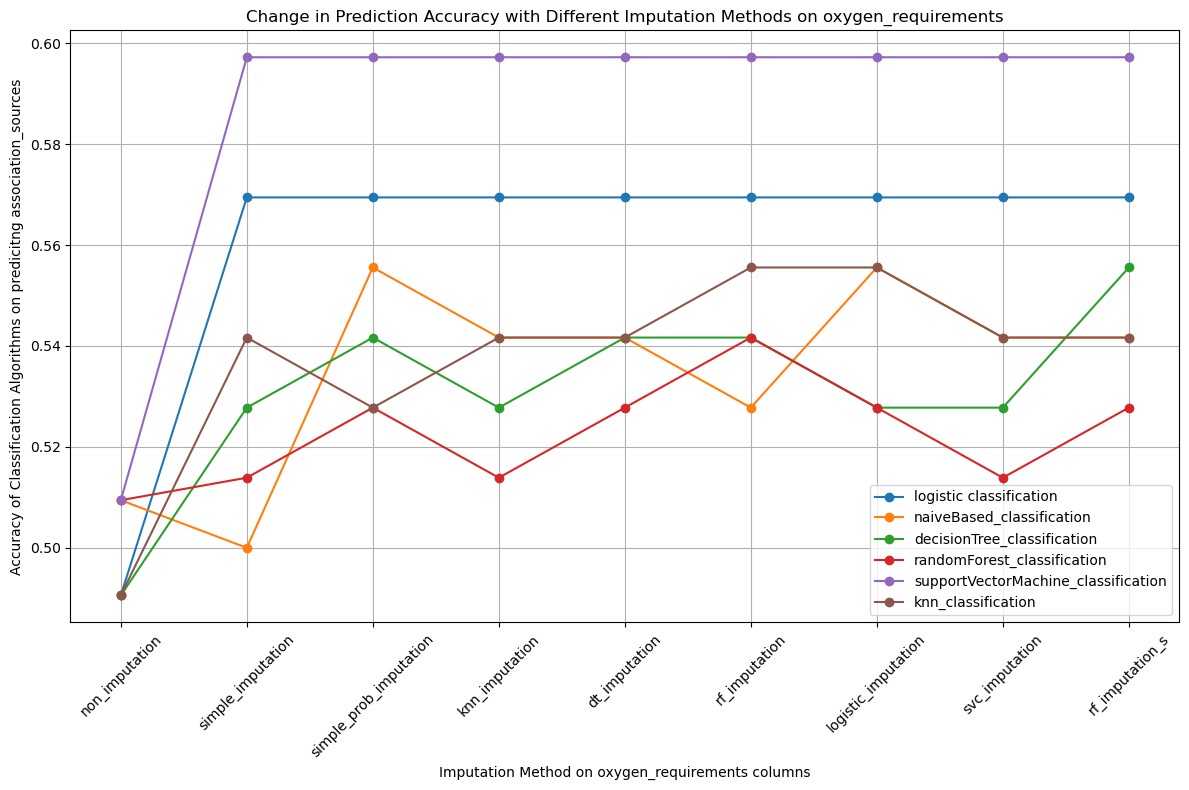

In [453]:


def plot_results(imputation_results):
    '''
    Plot the change in prediction accuracy of different classification algorithms with different imputation methods.
    
    Parameters:
    imputation_results (pd.DataFrame): The DataFrame containing the accuracy results.
    '''
    plt.figure(figsize=(12, 8))
    for algorithm in imputation_results['Algorithm'].unique():
        subset = imputation_results[imputation_results['Algorithm'] == algorithm]
        plt.plot(subset['imputation_method'], subset['accuracy'], marker='o', label=algorithm)

    plt.title('Change in Prediction Accuracy with Different Imputation Methods on oxygen_requirements')
    plt.xlabel('Imputation Method on oxygen_requirements columns')
    plt.ylabel('Accuracy of Classification Algorithms on predicitng association_sources')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming imputation_results is already defined and populated
plot_results(imputation_results)

In [454]:
original = imputation_results[imputation_results['imputation_method'] == 'non_imputation']
original

,Algorithm,imputation_method,accuracy
0,logistic classification,non_imputation,0.490566
9,naiveBased_classification,non_imputation,0.509434
18,decisionTree_classification,non_imputation,0.490566
27,randomForest_classification,non_imputation,0.509434
36,supportVectorMachine_classification,non_imputation,0.509434
45,knn_classification,non_imputation,0.490566


In [455]:
def find_average_improvement(df):
    compare = original.merge(df, on='Algorithm', suffixes=('_original', '_imputed'))
    diff = ((compare['accuracy_imputed'] - compare['accuracy_original']) / compare['accuracy_original']).mean()
    return diff

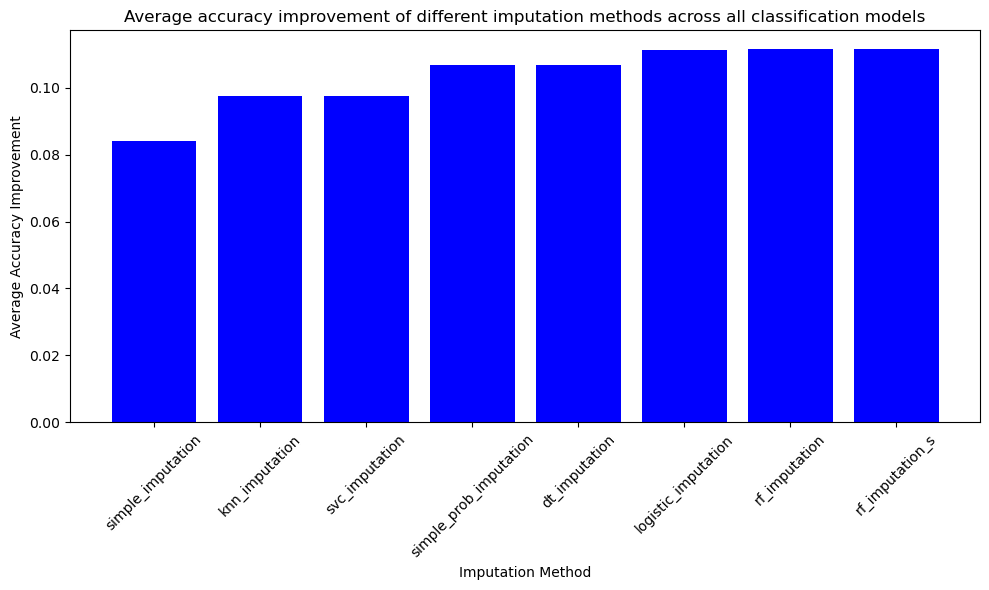

In [477]:
averge_improvement = imputation_results[imputation_results['imputation_method'] != 'non_imputation'].groupby('imputation_method').apply(find_average_improvement).sort_values().reset_index().rename(columns={0: 'Average Improvment'})

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(averge_improvement['imputation_method'], averge_improvement['Average Improvment'], color='blue')
plt.title('Average accuracy improvement of different imputation methods across all classification models')
plt.xlabel('Imputation Method')
plt.ylabel('Average Accuracy Improvement')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Final imputation on oxygen_requirement 

In [478]:
FEAUTRES = ['superkingdom', 'created_at_m', 'update_at_m', 'phylum', 'klass']
PREDICTOR = ['oxygen_requirement']

In [479]:
to_predict_df = cleaned_microbe_dataSet[FEAUTRES + PREDICTOR]
# fill up the nan value in feature column
to_predict_df['phylum'] = to_predict_df['phylum'].fillna(to_predict_df['phylum'].value_counts().index[0])
to_predict_df['klass'] = to_predict_df['klass'].fillna(to_predict_df['klass'].value_counts().index[0])

# there are 700 missing values in oxygen_requirement
to_predict_df.isna().sum()

/var/folders/0y/gbwmzjp93k12t06yhk8_2p7h0000gn/T/ipykernel_58556/1616472584.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_predict_df['phylum'] = to_predict_df['phylum'].fillna(to_predict_df['phylum'].value_counts().index[0])
/var/folders/0y/gbwmzjp93k12t06yhk8_2p7h0000gn/T/ipykernel_58556/1616472584.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_predict_df['klass'] = to_predict_df['klass'].fillna(to_predict_df['klass'].value_counts().index[0])


superkingdom            0
created_at_m            0
update_at_m             0
phylum                  0
klass                   0
oxygen_requirement    705
dtype: int64

In [480]:
# split the data set into training and testing

to_train = to_predict_df[to_predict_df['oxygen_requirement'].notna()]
to_predict = to_predict_df[to_predict_df['oxygen_requirement'].isna()]

In [481]:
X_train, X_test, y_train, y_test = train_test_split(to_train[FEAUTRES], to_train[PREDICTOR], test_size=0.2, random_state=42)

In [485]:

# needs to 
param_grid = {
    'n_estimators': [ 150, 200, 210],
    'max_depth': [None, 30, 40],
    'min_samples_split': [3, 5, 7],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False]
}
rf = RandomForestClassifier(random_state=42)

encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(X_train)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=4, n_jobs=-1, scoring='accuracy')

grid_search.fit(X_encoded, y_train)

best_params = grid_search.best_params_
best_params

/opt/anaconda3/envs/scripps_microbiome/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/opt/anaconda3/envs/scripps_microbiome/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/scripps_microbiome/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/scripps_microbiome/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y wa

{'bootstrap': True,
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 200}

In [486]:
# model's status
encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(X_test)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_encoded)
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.6190476190476191

In [488]:
# final imputation -- constructing the model by taking in all the training data 
encoder = OrdinalEncoder()
final_X_train = encoder.fit_transform(to_train.drop(columns=['oxygen_requirement']))
final_X_train

final_model = best_model.fit(final_X_train, to_train['oxygen_requirement'])

encoder = OrdinalEncoder()
final_X_predict = encoder.fit_transform(to_predict[FEAUTRES])

# predict the missing value
to_impute = final_model.predict(final_X_predict)

to_predict['oxygen_requirement'] = to_impute
to_predict

/var/folders/0y/gbwmzjp93k12t06yhk8_2p7h0000gn/T/ipykernel_58556/3574601666.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_predict['oxygen_requirement'] = to_impute


,superkingdom,created_at_m,update_at_m,phylum,klass,oxygen_requirement
3,Bacteria,9,8,Proteobacteria,Gammaproteobacteria,Anaerobe
45,Bacteria,9,8,Actinobacteria,Actinobacteria,Anaerobe
53,Bacteria,9,8,Actinobacteria,Actinobacteria,Anaerobe
74,Archaea,9,3,Euryarchaeota,Thermoplasmata,Anaerobe
77,Bacteria,9,8,Firmicutes,Clostridia,Anaerobe
...,...,...,...,...,...,...
2159,Bacteria,2,8,Firmicutes,Tissierellia,Anaerobe
2162,Bacteria,2,8,Tenericutes,Mollicutes,Anaerobe
2163,Bacteria,2,8,Tenericutes,Mollicutes,Anaerobe
2172,Archaea,3,3,Nitrososphaerota,Nitrososphaeria,Anaerobe


In [489]:
# creating imputated data set

temp = pd.concat([to_train, to_predict]).sort_index()
temp

to_predict_df['imputed_oxygen_requirement'] = temp['oxygen_requirement']
to_predict_df

/var/folders/0y/gbwmzjp93k12t06yhk8_2p7h0000gn/T/ipykernel_58556/2215423180.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_predict_df['imputed_oxygen_requirement'] = temp['oxygen_requirement']


,superkingdom,created_at_m,update_at_m,phylum,klass,oxygen_requirement,imputed_oxygen_requirement
0,Bacteria,9,8,Actinobacteria,Actinobacteria,Aerobe,Aerobe
1,Bacteria,9,8,Firmicutes,Negativicutes,Anaerobe,Anaerobe
2,Bacteria,9,8,Firmicutes,Negativicutes,Anaerobe,Anaerobe
3,Bacteria,9,8,Proteobacteria,Gammaproteobacteria,NaN,Anaerobe
4,Bacteria,9,8,Proteobacteria,Gammaproteobacteria,Aerobe,Aerobe
...,...,...,...,...,...,...,...
2169,Archaea,11,8,Euryarchaeota,Halobacteria,Aerobe,Aerobe
2170,Archaea,12,12,Candidatus thermoplasmatota,Thermoplasmata,Anaerobe,Anaerobe
2171,Archaea,6,8,Euryarchaeota,Halobacteria,Aerobe,Aerobe
2172,Archaea,3,3,Nitrososphaerota,Nitrososphaeria,NaN,Anaerobe


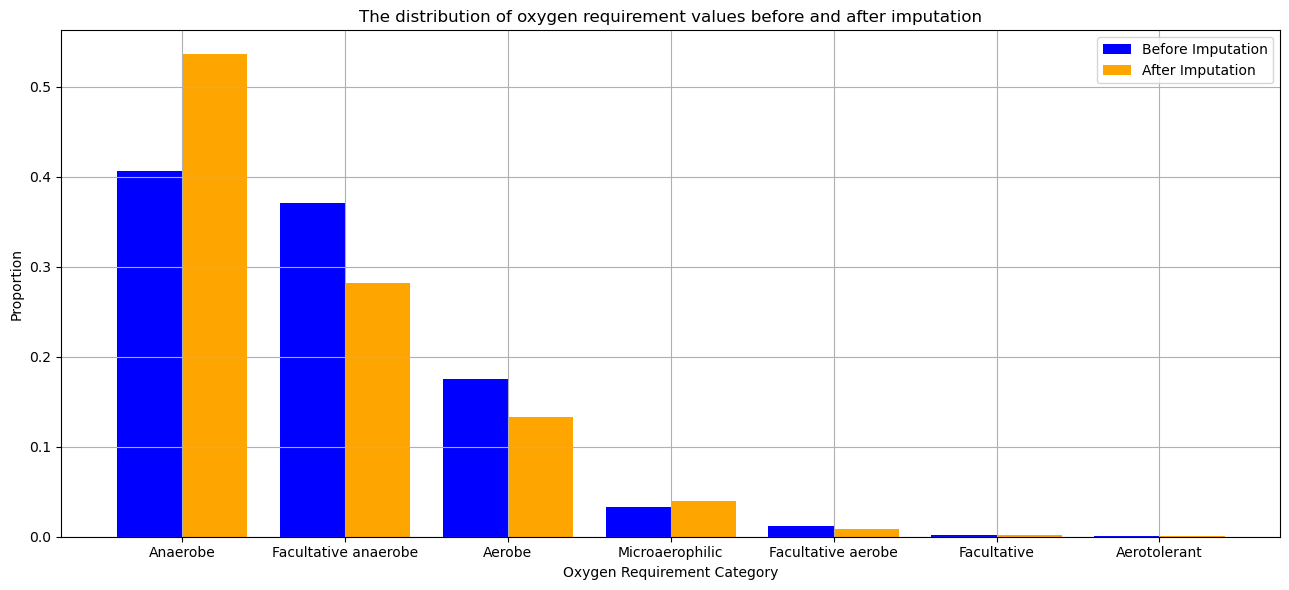

In [491]:
# comparing the distribution of imputated dataframe before and after the imputation

# Count the occurrences of each category in the original and imputed columns
original_counts = to_predict_df['oxygen_requirement'].value_counts(normalize = True)
imputed_counts = to_predict_df['imputed_oxygen_requirement'].value_counts(normalize = True)

# Combine the counts into a single DataFrame
combined_counts = pd.DataFrame({
    'Original': original_counts,
    'Imputed': imputed_counts
}).fillna(0)  # Fill NaN values with 0

# Plot overlapping bar plots
plt.figure(figsize=(13, 6))
width = 0.4  # Width of the bars

# Positions of the bars on the x-axis
positions = range(len(combined_counts))

# Bar plot for original oxygen_requirement
plt.bar(positions, combined_counts['Original'], width=width, label='Before Imputation', color='blue')

# Bar plot for imputed_oxygen_requirement
plt.bar([p + width for p in positions], combined_counts['Imputed'], width=width, label='After Imputation', color='orange')

# Adding labels and title
plt.xlabel('Oxygen Requirement Category')
plt.ylabel('Proportion')
plt.title('The distribution of oxygen requirement values before and after imputation')
plt.xticks([p + width / 2 for p in positions], combined_counts.index)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [495]:
# using the imputated data to predict the association_sources

to_predict_df['tax_id'] = cleaned_microbe_dataSet['ncbi_tax_id']
final_imputed_df = to_predict_df.merge(taxid_sources, left_on = 'tax_id', right_on = 'subject_taxid', how = 'inner')

imputation_eval_final = imputation_eval({'final_imputation': final_imputed_df}, 
                {'logistic classification': logistic_regression_classification,
                'naiveBased_classification': naiveBased_classification,
                'decisionTree_classification': decisionTree_classification,
                'randomForest_classification': randomForest_classification,
                'supportVectorMachine_classification': supportVectorMachine_classification,
                'knn_classification': knn_classification})
imputation_eval_final.mean()

/var/folders/0y/gbwmzjp93k12t06yhk8_2p7h0000gn/T/ipykernel_58556/2057380851.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_predict_df['tax_id'] = cleaned_microbe_dataSet['ncbi_tax_id']
/opt/anaconda3/envs/scripps_microbiome/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/scrip

accuracy    0.461111
dtype: float64